In [1]:
import os
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
key = '74e5f976587b1e5e3ac6b21b77eeb9b6b7a88822'

df = pdr.get_data_tiingo('AAPL', api_key=key)
df.head()

close   high    low    open    volume  \
symbol date                                                               
AAPL   2016-05-02 00:00:00+00:00  93.64  94.08  92.40  93.965  48160104   
       2016-05-03 00:00:00+00:00  95.18  95.74  93.68  94.200  56831277   
       2016-05-04 00:00:00+00:00  94.19  95.90  93.82  95.200  41025475   
       2016-05-05 00:00:00+00:00  93.24  94.07  92.68  94.000  35890500   
       2016-05-06 00:00:00+00:00  92.72  93.45  91.85  93.370  43699886   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
AAPL   2016-05-02 00:00:00+00:00  21.770058  21.872352  21.481774  21.845616   
       2016-05-03 00:00:00+00:00  22.128088  22.258280  21.779357  21.900251   
       2016-05-04 00:00:00+00:00  21.897926  22.295478  21.811906  22.132737   
       2016-05-05 00:00:00+00:00  21.809581  22.003724  21.678592  21.987351   
       2016-05-06 00:00:00+00:00  21.687949  21.858701  21.484449  21.839989   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2016-05-02 00:00:00+00:00  192640416     0.00          1.0  
       2016-05-03 00:00:00+00:00  227325108     0.00          1.0  
       2016-05-04 00:00:00+00:00  164101900     0.00          1.0  
       2016-05-05 00:00:00+00:00  143562000     0.57          1.0  
       2016-05-06 00:00:00+00:00  174799544     0.00          1.0

In [3]:
df.to_csv('AAPL.csv')

In [4]:
df = pd.read_csv('AAPL.csv')

In [5]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2021-04-23 00:00:00+00:00,134.32,135.12,132.16,132.16,78756779,134.32,135.12,132.16,132.16,78756779,0.0,1.0
1254,AAPL,2021-04-26 00:00:00+00:00,134.72,135.06,133.56,134.83,66905069,134.72,135.06,133.56,134.83,66905069,0.0,1.0
1255,AAPL,2021-04-27 00:00:00+00:00,134.39,135.41,134.11,135.01,66015804,134.39,135.41,134.11,135.01,66015804,0.0,1.0
1256,AAPL,2021-04-28 00:00:00+00:00,133.58,135.02,133.08,134.31,107760097,133.58,135.02,133.08,134.31,107760097,0.0,1.0
1257,AAPL,2021-04-29 00:00:00+00:00,133.48,137.07,132.45,136.47,151100953,133.48,137.07,132.45,136.47,151100953,0.0,1.0


In [6]:
df1 = df.reset_index()['close']

In [7]:
df1.shape

(1258,)

In [8]:
df1

0        93.64
1        95.18
2        94.19
3        93.24
4        92.72
         ...  
1253    134.32
1254    134.72
1255    134.39
1256    133.58
1257    133.48
Name: close, Length: 1258, dtype: float64

Text(0, 0.5, 'Stock Price')

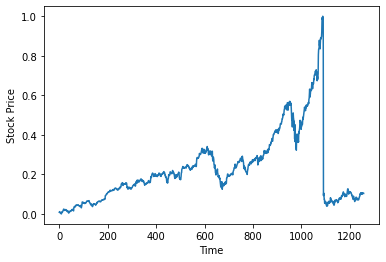

In [62]:
plt.plot(df1)
plt.xlabel("Time")
plt.ylabel("Stock Price")

In [10]:
# LSTM very sensitive to scale of data. Thus, standardise using MinMax scaler

In [11]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape (-1,1))

In [12]:
df1.shape

(1258, 1)

In [13]:
df1

array([[0.00793746],
       [0.01164161],
       [0.00926037],
       ...,
       [0.1059531 ],
       [0.10400481],
       [0.10376428]])

In [14]:
# Splitting the data based on history
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [15]:
len(train_data)

817

In [16]:
# Prepare a time series prediction dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]   #0,1,2......99  y_test - 100
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [17]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [18]:
print((x_test.shape))

(340, 100)


In [19]:
print((y_test).shape)

(340,)


In [20]:
# reshape Input to be [samples, time steps, features] required for lstm.
# time steps and features are given as input to lstm
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

In [21]:
# model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose =1)

Epoch 1/100
12/12 [==============================] - 4s 331ms/step - loss: 0.0106 - val_loss: 0.0508
Epoch 2/100
12/12 [==============================] - 2s 140ms/step - loss: 0.0025 - val_loss: 0.0271
Epoch 3/100
12/12 [==============================] - 2s 141ms/step - loss: 0.0013 - val_loss: 0.0230
Epoch 4/100
12/12 [==============================] - 2s 139ms/step - loss: 6.1320e-04 - val_loss: 0.0203
Epoch 5/100
12/12 [==============================] - 2s 144ms/step - loss: 4.5712e-04 - val_loss: 0.0203
Epoch 6/100
12/12 [==============================] - 2s 139ms/step - loss: 4.2429e-04 - val_loss: 0.0193
Epoch 7/100
12/12 [==============================] - 2s 138ms/step - loss: 4.1811e-04 - val_loss: 0.0189
Epoch 8/100
12/12 [==============================] - 2s 137ms/step - loss: 4.2911e-04 - val_loss: 0.0184
Epoch 9/100
12/12 [==============================] - 2s 192ms/step - loss: 3.6697e-04 - val_loss: 0.0180
Epoch 10/100
12/12 [==============================] - 2s 194ms/step

In [25]:
# Prediction and Performance matrix
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

In [26]:
# Transform from standardisation back to original form
pred_train = scaler.inverse_transform(pred_train)
pred_test = scaler.inverse_transform(pred_test)

In [50]:
# Calculate RMSE performance matrix
import math
from sklearn.metrics import mean_squared_error
rmse_train = math.sqrt(mean_squared_error(y_train, pred_train))
print("The Root Mean Squared Error for training was found to be - ",rmse_train)

The Root Mean Squared Error for training was found to be -  172.22455129309478


In [51]:
rmse_test = math.sqrt(mean_squared_error(y_test, pred_test))
print("The Root Mean Squared Error for test was found to be - ",rmse_test)

The Root Mean Squared Error for test was found to be -  258.17921083446487


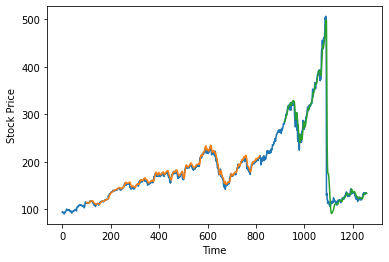

In [52]:
# Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(pred_train)+look_back, :] = pred_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(pred_train)+(look_back*2)+1:len(df1)-1, :] = pred_test
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

# Orange - Train
# Green - Test

In [30]:
# We want to predict price of stock for next 30 days
# Thus, we take data 100 days before last date
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [32]:
temp_input

[0.07675285628382439,
 0.08036079374624172,
 0.08187612748045697,
 0.07562236921226695,
 0.0791340950090198,
 0.07713770294648226,
 0.07562236921226695,
 0.0902946482260974,
 0.0901262778111846,
 0.09226698737221883,
 0.08734816596512324,
 0.0911365003006614,
 0.09991581479254358,
 0.09770294648226097,
 0.10013229104028859,
 0.11148526758869509,
 0.10710763680096214,
 0.1043415514131088,
 0.10186410102224891,
 0.09397474443776305,
 0.0978232110643415,
 0.08721587492483462,
 0.09760673481659649,
 0.10032471437161755,
 0.09294046903187009,
 0.09250751653638006,
 0.09753457606734811,
 0.09277209861695729,
 0.08851473241130486,
 0.09017438364401681,
 0.10027660853878534,
 0.11191822008418523,
 0.11720986169573056,
 0.12647023451593503,
 0.1270475045099218,
 0.12440168370414911,
 0.11244738424533973,
 0.10010823812387254,
 0.10535177390258565,
 0.10739627179795552,
 0.10487071557426336,
 0.11316897173782314,
 0.11165363800360789,
 0.11201443174984965,
 0.10984966927239925,
 0.10835838845460

In [55]:
# demonstrate prediction for next 30 days
from numpy import array
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,100,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

0 day input [0.07165364 0.07475646 0.06258569 0.07395069 0.07129284 0.07605532
 0.0738184  0.08093806 0.08473842 0.08279014 0.07261575 0.0713169
 0.07949489 0.07745039 0.07155743 0.07276007 0.07425135 0.07468431
 0.07110042 0.07651233 0.07855683 0.08553217 0.08627781 0.09034275
 0.09625977 0.10259771 0.09837643 0.10604931 0.10027661 0.10621768
 0.10539988 0.10703548 0.10287432 0.10381239 0.10006013 0.10578473
 0.10674684 0.1059531  0.10400481 0.10376428 0.10658351 0.10713498
 0.10788871 0.1088108  0.10984773 0.11095544 0.1121038  0.11327328
 0.11445093 0.11562804 0.11679853 0.11795861 0.1191064  0.12024178
 0.12136586 0.12248102 0.12359026 0.12469711 0.12580527 0.12691839
 0.12803994 0.12917309 0.13032044 0.13148431 0.13266647 0.13386826
 0.13509063 0.13633414 0.13759913 0.13888565 0.14019361 0.14152279
 0.14287306 0.14424413 0.1456358  0.14704794 0.1484805  0.14993359
 0.15140723 0.15290178 0.15441756 0.155955   0.15751457 0.15909691
 0.16070269 0.16233246 0.16398709 0.16566728 0.1673

 0.19671009 0.19895844 0.20124975 0.20358531]
7 day output [[0.20596668]]
8 day input [0.08473842 0.08279014 0.07261575 0.0713169  0.07949489 0.07745039
 0.07155743 0.07276007 0.07425135 0.07468431 0.07110042 0.07651233
 0.07855683 0.08553217 0.08627781 0.09034275 0.09625977 0.10259771
 0.09837643 0.10604931 0.10027661 0.10621768 0.10539988 0.10703548
 0.10287432 0.10381239 0.10006013 0.10578473 0.10674684 0.1059531
 0.10400481 0.10376428 0.10658351 0.10713498 0.10788871 0.1088108
 0.10984773 0.11095544 0.1121038  0.11327328 0.11445093 0.11562804
 0.11679853 0.11795861 0.1191064  0.12024178 0.12136586 0.12248102
 0.12359026 0.12469711 0.12580527 0.12691839 0.12803994 0.12917309
 0.13032044 0.13148431 0.13266647 0.13386826 0.13509063 0.13633414
 0.13759913 0.13888565 0.14019361 0.14152279 0.14287306 0.14424413
 0.1456358  0.14704794 0.1484805  0.14993359 0.15140723 0.15290178
 0.15441756 0.155955   0.15751457 0.15909691 0.16070269 0.16233246
 0.16398709 0.16566728 0.16737376 0.16910741 

16 day output [[0.22973613]]
17 day input [0.07468431 0.07110042 0.07651233 0.07855683 0.08553217 0.08627781
 0.09034275 0.09625977 0.10259771 0.09837643 0.10604931 0.10027661
 0.10621768 0.10539988 0.10703548 0.10287432 0.10381239 0.10006013
 0.10578473 0.10674684 0.1059531  0.10400481 0.10376428 0.10658351
 0.10713498 0.10788871 0.1088108  0.10984773 0.11095544 0.1121038
 0.11327328 0.11445093 0.11562804 0.11679853 0.11795861 0.1191064
 0.12024178 0.12136586 0.12248102 0.12359026 0.12469711 0.12580527
 0.12691839 0.12803994 0.12917309 0.13032044 0.13148431 0.13266647
 0.13386826 0.13509063 0.13633414 0.13759913 0.13888565 0.14019361
 0.14152279 0.14287306 0.14424413 0.1456358  0.14704794 0.1484805
 0.14993359 0.15140723 0.15290178 0.15441756 0.155955   0.15751457
 0.15909691 0.16070269 0.16233246 0.16398709 0.16566728 0.16737376
 0.16910741 0.17086898 0.17265929 0.17447922 0.17632958 0.17821123
 0.18012515 0.18207204 0.18405309 0.18606903 0.18812102 0.19020998
 0.19233708 0.19450337 

25 day output [[0.25887525]]
26 day input [0.09837643 0.10604931 0.10027661 0.10621768 0.10539988 0.10703548
 0.10287432 0.10381239 0.10006013 0.10578473 0.10674684 0.1059531
 0.10400481 0.10376428 0.10658351 0.10713498 0.10788871 0.1088108
 0.10984773 0.11095544 0.1121038  0.11327328 0.11445093 0.11562804
 0.11679853 0.11795861 0.1191064  0.12024178 0.12136586 0.12248102
 0.12359026 0.12469711 0.12580527 0.12691839 0.12803994 0.12917309
 0.13032044 0.13148431 0.13266647 0.13386826 0.13509063 0.13633414
 0.13759913 0.13888565 0.14019361 0.14152279 0.14287306 0.14424413
 0.1456358  0.14704794 0.1484805  0.14993359 0.15140723 0.15290178
 0.15441756 0.155955   0.15751457 0.15909691 0.16070269 0.16233246
 0.16398709 0.16566728 0.16737376 0.16910741 0.17086898 0.17265929
 0.17447922 0.17632958 0.17821123 0.18012515 0.18207204 0.18405309
 0.18606903 0.18812102 0.19020998 0.19233708 0.19450337 0.19671009
 0.19895844 0.20124975 0.20358531 0.20596668 0.2083953  0.21087271
 0.21340068 0.21598099

In [56]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

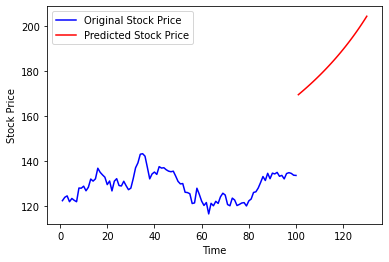

In [57]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]), color = 'blue',
        label = 'Original Stock Price')
plt.plot(day_pred,scaler.inverse_transform(lst_output), color = 'red',
        label = 'Predicted Stock Price')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()

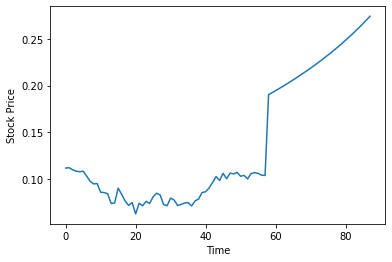

In [60]:
df3=df1.tolist()
df3.extend(lst_output)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.plot(df3[1200:])

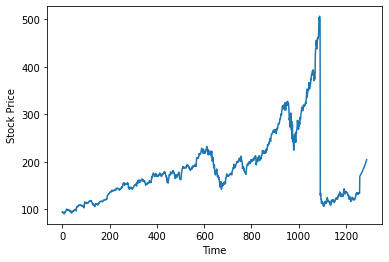

In [61]:
df3=scaler.inverse_transform(df3).tolist()
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.plot(df3)